# Hurricane Path Predictor
Predicts which zones a hurricane will hit based on past hurricane data. The US National Hurricane Center provided a dataset of hurricane information from 1851 to 2016 in their HURDAT2 dataset.

![alt text](USA_zones.png)
<center>(Figure 1) Hurricane Zones</center>

### Key Terms

**Storm Status Codes**
* WV - Tropical Wave
* TD - Tropical Depression
* TS - Tropical Storm
* HU - Hurricane
* EX - Extratropical cyclone
* SD - Subtropical depression (winds <34 kt)
* SS - Subtropical storm (winds >34 kt)
* LO - A low pressure system not fitting any of above descriptions
* DB - non-tropical Disturbance not have a closed circulation

"Event" refers to the time-series of measurements of one storm

### Importing the Data

Importing python modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

Customizing graphs

In [2]:
custom_style = {'axes.axisbelow': True,
                'axes.edgecolor': 'white',
                'axes.facecolor': '#3C4053',
                'axes.facecolor':'#3C4053',
                'figure.facecolor':'#3C4053',
                'axes.grid': True,
                'axes.labelcolor': 'grey',
                'axes.linewidth': 0,
                'grid.color': 'grey',
                'grid.linestyle': '-',
                'image.cmap': 'Greys',
                'legend.frameon': False,
                'legend.numpoints': 1,
                'legend.scatterpoints': 1,
                'lines.solid_capstyle': 'round',
                'pdf.fonttype': 42,
                'text.color': 'white',
                'xtick.color': 'white',
                'xtick.direction': 'out',
                'xtick.major.size': 0,
                'xtick.minor.size': 0,
                'ytick.color': 'white',
                'ytick.direction': 'out',
                'ytick.major.size': 0,
                'ytick.minor.size': 0}
sns.set(font_scale=1.7, style='darkgrid', rc=custom_style)

Read .csv file line-by-line

In [3]:
with open('hurdat2-1851-2016-041117.csv', 'r') as f: 
       file_data = [row.strip().split(',') for row in f]

Convert data file to data frame

In [4]:
df = pd.DataFrame(file_data)

### Cleaning the Data

Delete columns with missing or incomplete data

In [5]:
df.drop([2] + list(range(7,21)), axis='columns', inplace=True)

Renaming columns

In [6]:
data = pd.DataFrame(np.matrix(df),
                    columns=['date', 'time', 'status', 'lat', 'lon', 'max_wind'])

Encoding the header row for a new hurricane storm

In [7]:
def time_convert(time_str):
    try:
        return(int(time_str.strip()))
    except:
        pass
data.date = data.date.apply(lambda x: '99999999' if x[0] == 'A' else x.strip())
data.time = data.time.apply(lambda x: x.strip())
data.status = data.status.apply(lambda x: 'NE' if x == '' else x.strip())
data.lat = data.lat.apply(lambda x: '00.0N' if x is None else x.strip())
data.lon = data.lon.apply(lambda x: '00.0W' if x is None else x.strip())
data.max_wind = data.max_wind.apply(lambda x: 0 if x is None else int(x.strip()))

30.0

Only 'North' latitudes in the data set

In [8]:
lst = []
for x in data.lat:
    if x is not None:
        lst.append(x[-1])
lst = set(lst)
print(lst)

{'N'}


'West' and 'East' longitudes in the data set

In [9]:
lst = []
for x in data.lon:
    if x is not None:
        lst.append(x[-1])
lst = set(lst)
print(lst)

{'E', 'W'}


Converting latitude to float data type

In [10]:
data.lat = data.lat.apply(lambda x: float(x.strip()[:-1]))

Converting longitude to float data type

In [11]:
def lon_convert(lon):
    lon = lon.strip()
    lon_sign = 1
    if lon[-1] == 'W':
        lon_sign = -1
    return(lon_sign * float(lon[:-1]))
data.lon = data.lon.apply(lambda x: lon_convert(x))
data = data[data.lon > -200]    # Dropping noise

Identifying noise in the time column

In [12]:
def time_filter(t):
    try:
        int(t)
        return(t)
    except:
        return('9999')
data.time = data.time.apply(lambda x: time_filter(x))

Extract date information

In [13]:
data.loc[:, 'year'] = data.date.apply(lambda x: int(x[0:4]))
data.loc[:, 'month'] = data.date.apply(lambda x: int(x[4:6]))
data.loc[:, 'day'] = data.date.apply(lambda x: int(x[6:8]))
data.drop('date', axis='columns', inplace=True)

Extract time information

In [14]:
data.loc[:, 'hour'] = data.time.apply(lambda x: int(x[0:2]))
data.loc[:, 'minute'] = data.time.apply(lambda x: int(x[2:4]))
data.drop('time', axis='columns', inplace=True)

In [15]:
statuses = set(data.status)

### Exploratory Data Analysis

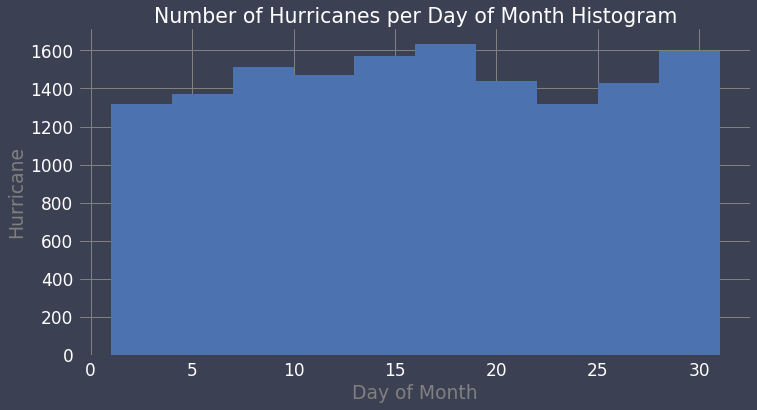

In [16]:
plt.figure(figsize=(12, 6))
data[(data.day != 99) & (data.status == 'HU')].day.plot(kind='hist')
plt.title("Number of Hurricanes per Day of Month Histogram")
plt.xlabel("Day of Month")
plt.ylabel("Hurricane")
plt.show()

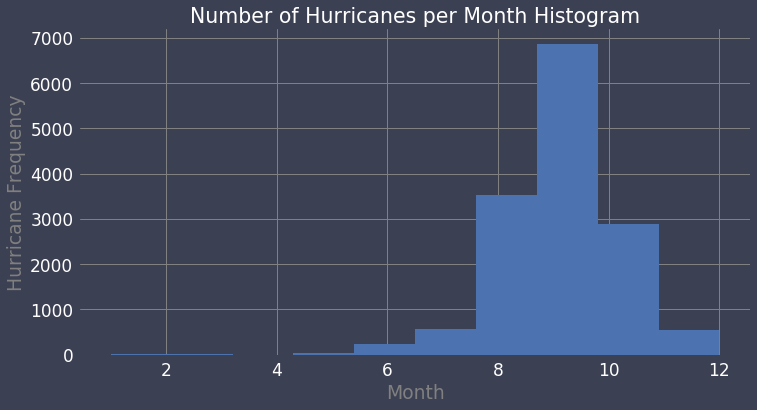

In [17]:
plt.figure(figsize=(12, 6))
data[(data.day != 99) & (data.status == 'HU')].month.plot(kind='hist')
plt.title("Number of Hurricanes per Month Histogram")
plt.xlabel("Month")
plt.ylabel("Hurricane Frequency")
plt.show()

Over 90% of hurricanes in the North Atlantic Basin occurred in August, September, and October

In [18]:
data[(data.day != 99) & ((data.month == 8) | (data.month == 9) | (data.month == 10)) &
     (data.status == 'HU')].shape[0] / data[(data.day != 99) & 
                                            (data.status == 'HU')].shape[0]

0.9042647560559536

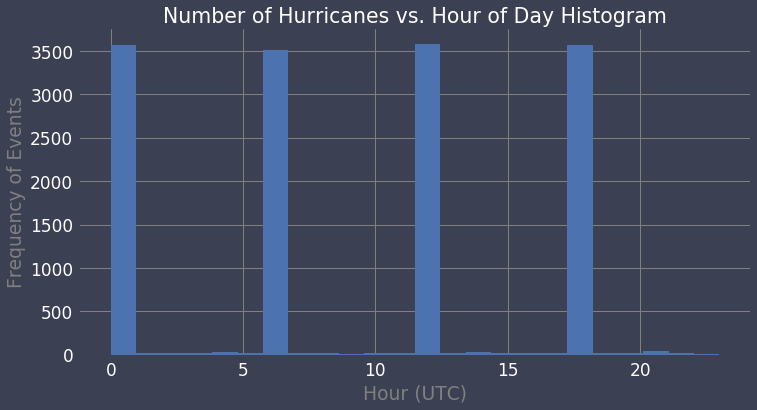

In [19]:
plt.figure(figsize=(12, 6))
data[(data.day != 99) & (data.status == 'HU')].hour.plot(kind='hist', bins=24)
plt.title("Number of Hurricanes vs. Hour of Day Histogram")
plt.xlabel("Hour (UTC)")
plt.ylabel("Frequency of Events")
plt.show()

This shows the recorded hour of the hurricane. This reflects data logging techniques.

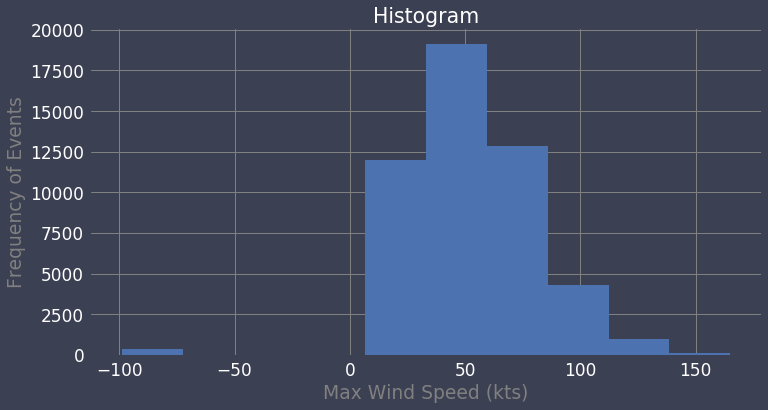

In [20]:
plt.figure(figsize=(12, 6))
data[(data.day != 99)].max_wind.plot(kind='hist')
plt.title("Histogram")
plt.xlabel("Max Wind Speed (kts)")
plt.ylabel("Frequency of Events")
plt.show()

The max wind histogram follows a Poisson distribution

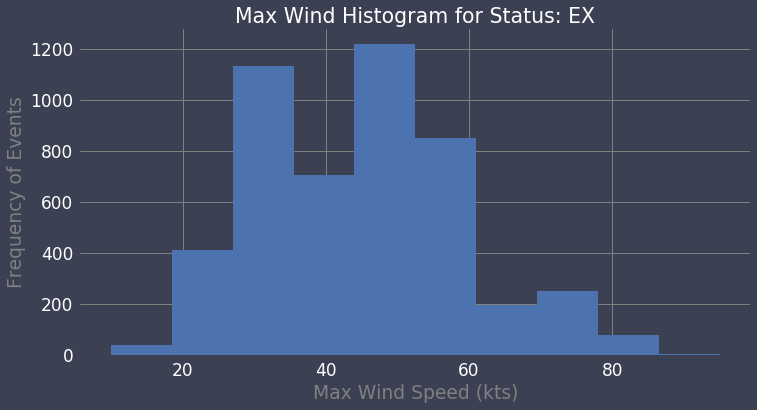

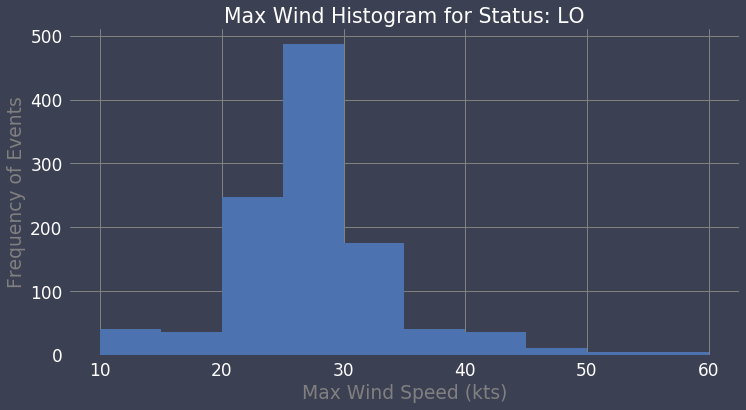

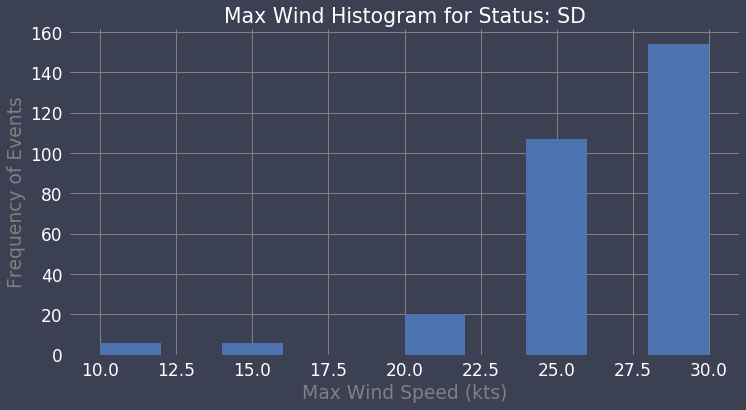

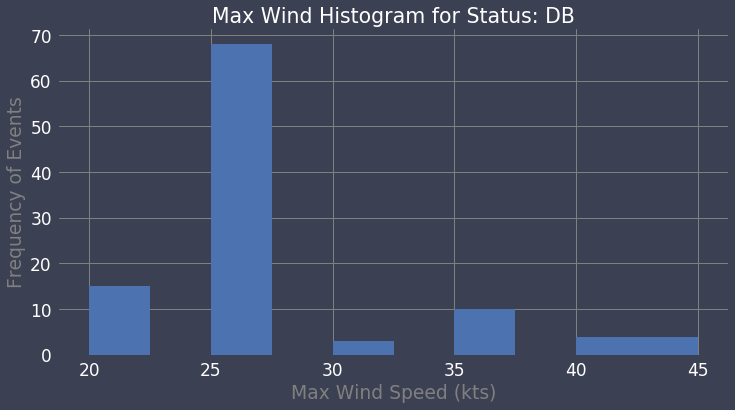

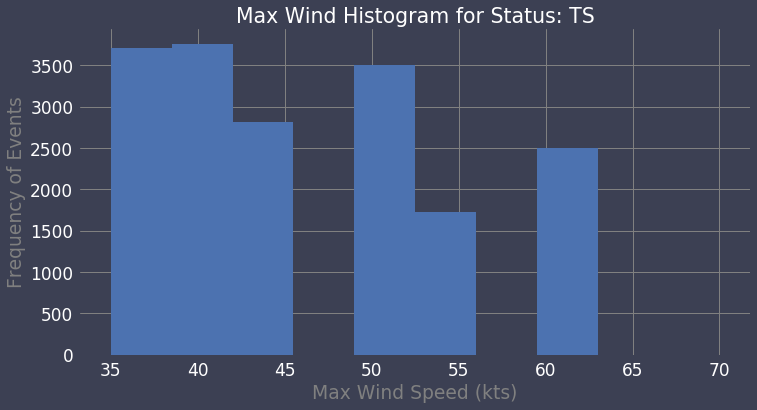

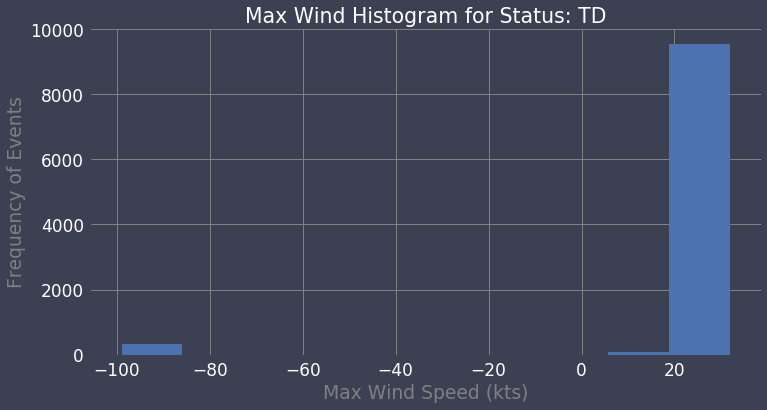

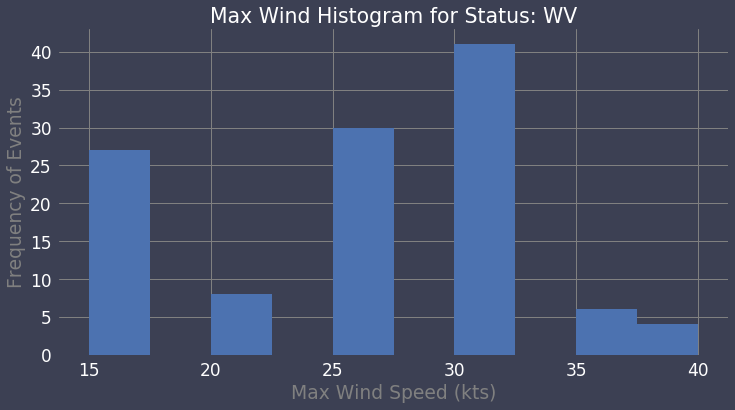

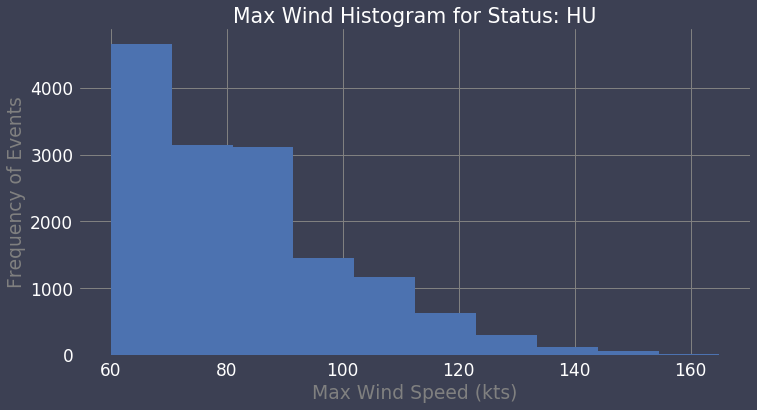

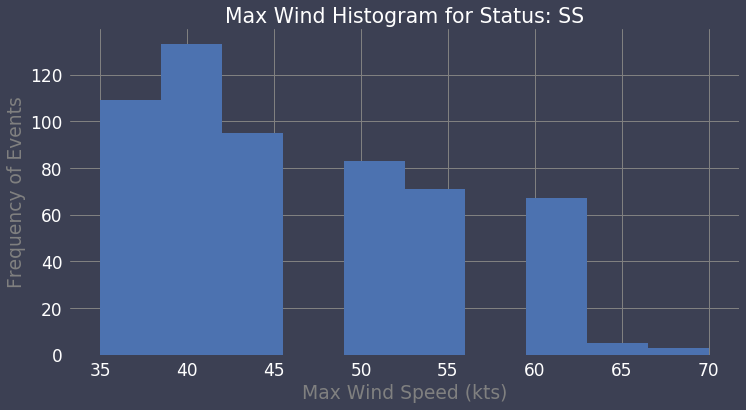

In [137]:
for status in statuses:
    if status != 'NE':
        plt.figure(figsize=(12, 6))
        data[(data.day != 99) & (data.status == status)].max_wind.plot(kind='hist')
        plt.title("Max Wind Histogram for Status: {}".format(status))
        plt.xlabel("Max Wind Speed (kts)")
        plt.ylabel("Frequency of Events")
        plt.show()

According to the histogram, hurricance's max wind speed is less than 100 kts most of the time

There are over 300 missing max wind speed measurements for tropic depressions

In [146]:
data[(data.day != 99) & (data.status == 'TD') & (data.max_wind < 0)].max_wind.count()

338

These are the only max wind speed missing values in the dataframe. Let's replace the missing values with the median wind speed va

In [149]:
data.max_wind = data.max_wind.apply(lambda x: 30 if x == -99 else x)

In [150]:
data[(data.day != 99) & (data.status == 'TD') & (data.max_wind < 0)].max_wind.count()

0

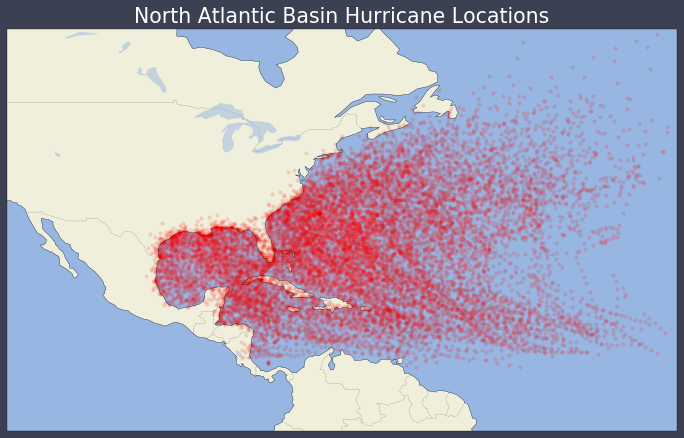

In [34]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-120, -20, 0, 60], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
plt.scatter(data[(data.day != 99) & (data.status == 'HU')].lon,
            data[(data.day != 99) & (data.status == 'HU')].lat,
            marker='.',
            color='#FF0000',
            alpha=0.15)
plt.title('North Atlantic Basin Hurricane Locations')
plt.show()

Let's examine the time between measurements

In [36]:
data.loc[:, 'hour_decimal'] = np.array(data.hour) + np.array(data.minute) / 60
data.loc[:, 'time_diff'] = data.hour_decimal.diff()

In [37]:
(data[(data.day != 99) & (data.time_diff == 6)].time_diff.count()) \
/ (data[(data.day != 99) & (data.time_diff > 0)].time_diff.count())

0.961160775684225

Over 96% of the time, there's a 6-hour gap between measurements

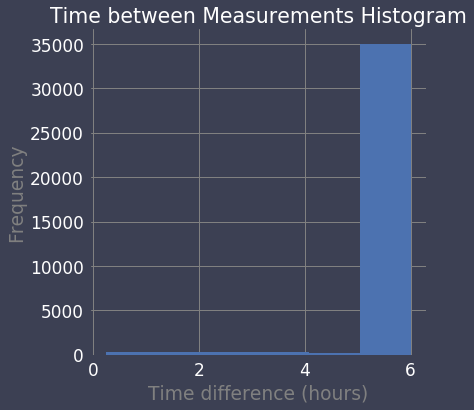

In [38]:
plt.figure(figsize=(6, 6))
data[(data.day != 99) & (data.time_diff > 0)].time_diff.hist(bins=6)
plt.title("Time between Measurements Histogram")
plt.ylabel('Frequency')
plt.xlabel('Time difference (hours)')
plt.show()

Most time gaps are 6 hours

Any multi-collinearity? Yes

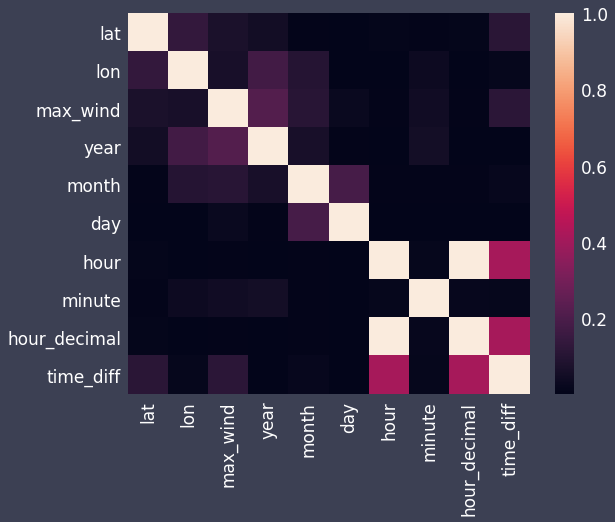

In [39]:
plt.figure(figsize=(9,7))
sns.heatmap(np.abs(data[data.day != 99].corr()));

Let's drop "hour" and "minute" because we created "hour_decimal"

In [40]:
data.drop(['hour', 'minute'], axis=1, inplace=True)

With the exception of "hour_decimal" and "time_diff", the features have little correlation with each other

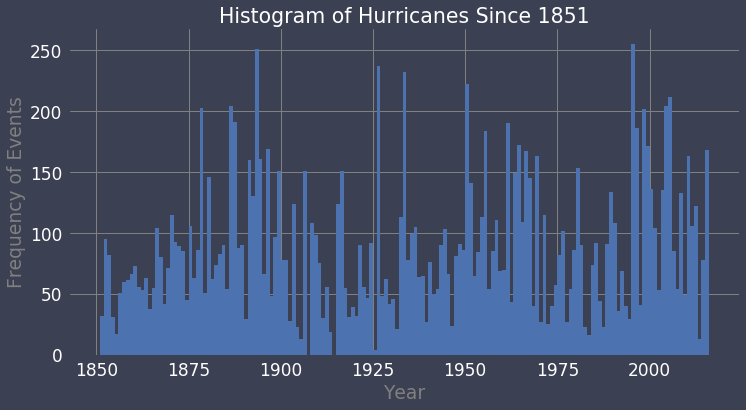

In [42]:
plt.figure(figsize=(12, 6))
data[(data.day != 99) & (data.status == 'HU')].year.plot(kind='hist', bins=165)
plt.title("Histogram of Hurricanes Since 1851")
plt.xlabel("Year")
plt.ylabel("Frequency of Events")
plt.show()

Possible sinusoidal pattern. Let's dig deeper.

'HU_years' is the below dataframe that contains measured hurricane (HU) events with maximum wind speed (max_wind) and time duration (time_diff)

In [113]:
HU_years = data[(data.day != 99) & (data.status == 'HU')][['year', 'max_wind', 
                                                                'time_diff']]

Filling in the median time duration for an event's first row

In [114]:
avg_time_diff = HU_years[HU_years.time_diff > 0].time_diff.mean()
HU_years.time_diff = HU_years.time_diff.apply(lambda x: x if x > 0
                                              else avg_time_diff)

An event's first row has no previous reference, so we replaced it with the column's median value

In [115]:
HU_years.head(3)

,year,max_wind,time_diff
1,1851,80,5.802339
2,1851,80,6.000000
3,1851,80,6.000000


Using energy to describe hurricance measuremed strength. Kinetic energy is proportional to $\frac{1}{2} mass \cdot  velocity ^{2}$

Since we do not have the hurricances' mass, we will work with the velocity. Kinetic energy is proportional to $velocity ^{2}$. We will use $velocity ^{2}$ as a metric for hurricane's energy.

In [116]:
HU_years.loc[:, 'energy'] = np.array(HU_years.max_wind)**2

Let's include the time duration by multiplying it with the hurricane's strength. We're assuming the hurricane maintained its strength throughout the measurement's duration.

In [119]:
HU_years.loc[:, 'energy-hours'] = np.array(HU_years.energy) * np.array(HU_years.time_diff)
HU_years.drop(['max_wind', 'time_diff', 'energy'], axis=1, inplace=True)

In [120]:
HU_years.head(3)

,year,energy-hours
1,1851,37134.969576
2,1851,38400.000000
3,1851,38400.000000


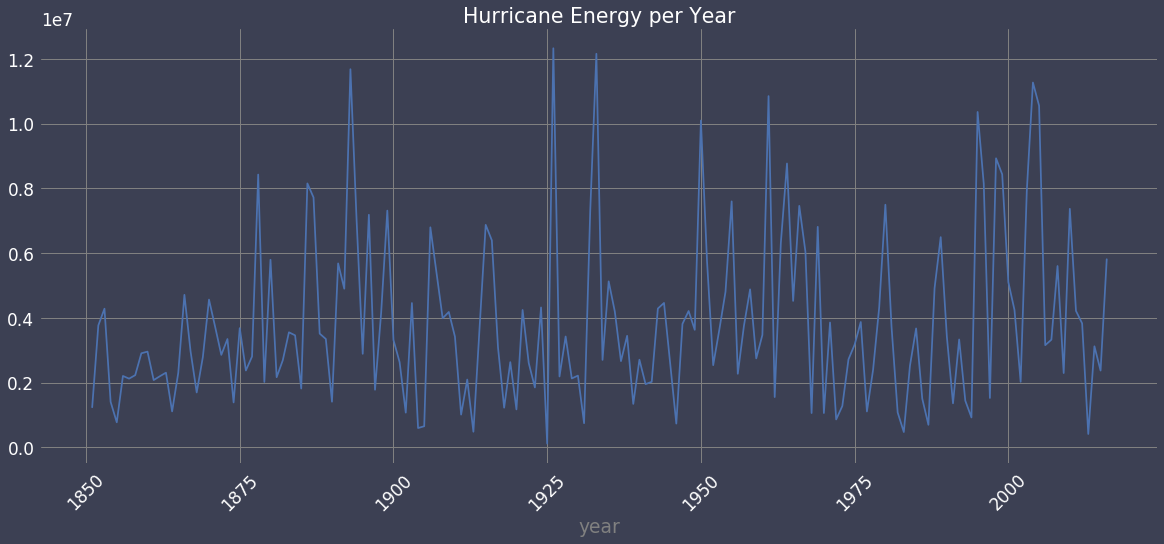

In [126]:
HU_energy_year = HU_years.groupby('year').sum()
HU_energy_year.plot(figsize=(20, 8),
                    legend=False,
                    rot=45,
                    title='Hurricane Energy per Year');

### Engineering Features